In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")


# Data Exploration and Preprocessing

## Matplotlib Plots

In [3]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [4]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [5]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [6]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [7]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [8]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)a
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [9]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Outliers

In [10]:
def explore_outliers(df,columns):
    number_df = df[columns].select_dtypes(include="number")
    n_columns = number_df.columns
    # normalização para ser visualmente perceptivel nos plots
    scaler = MinMaxScaler()
    number_df_scaled = pd.DataFrame(scaler.fit_transform(number_df),columns=n_columns)

    for i in range(0, len(n_columns),7):
        show_boxplot(df=number_df_scaled[n_columns[i:i+7]])
        
# esta função faz um loop de 7 em 7 colunas por todas as colunas do dataset para uma analise geral dos outliers.
# esta operacao é demorada e nao muito boa porque 2181 / 7 = 300 vezes


In [11]:
def detect_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar os outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    show_boxplot(title=f"{column} boxplot",df=df[[column]])

    print(outliers[column])

# IQR method 
## considera como outliers os dados que estao 1.5*IQR acima e abaixo do primeiro e terceiro quartil, respetivamente. IQR = Q3 - Q1

## Category Encoder and Decoder
bastante útil para poder codificar e posteriormente decodificar categorical features

In [12]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [13]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

## Basic Exploration

In [14]:
def main_exploration(df):
    print(df.shape) 

In [15]:
main_exploration(control_df)
main_exploration(train_df)
main_exploration(test_df)

(305, 2182)
(305, 2182)
(100, 2180)


In [16]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())
    detect_outliers(df,"Age")

In [17]:
numerical_exploration(train_df)

In [18]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())


In [19]:
categorical_exploration(train_df)

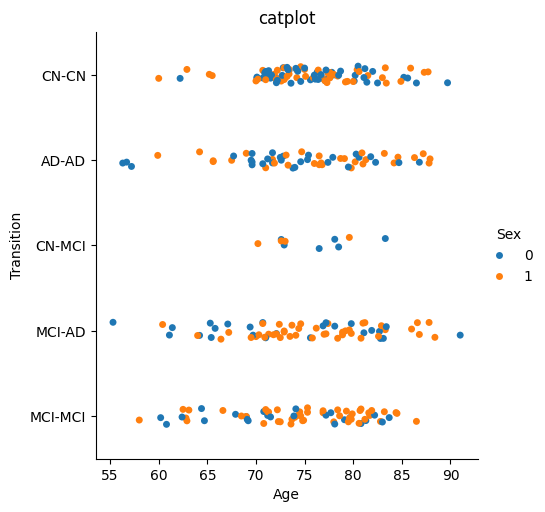

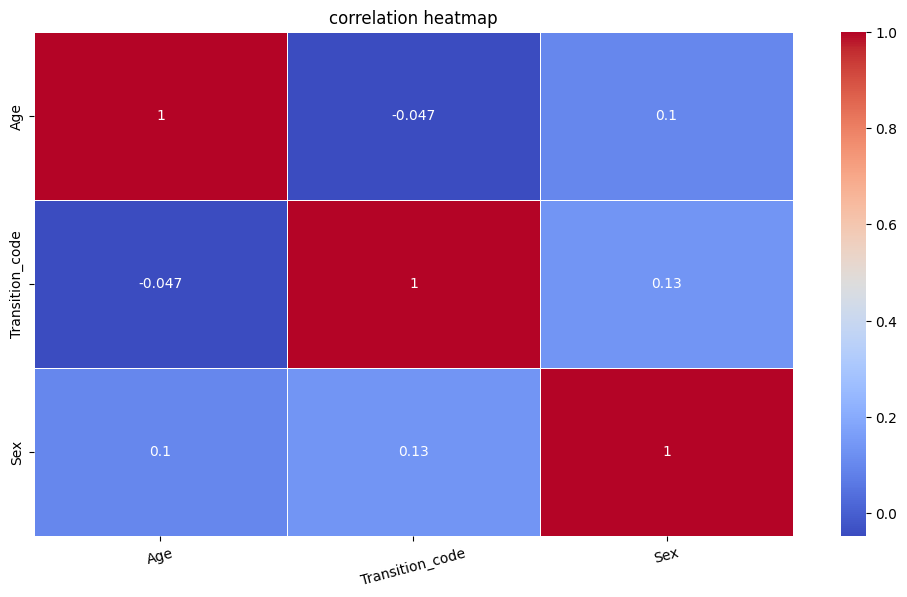

In [20]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

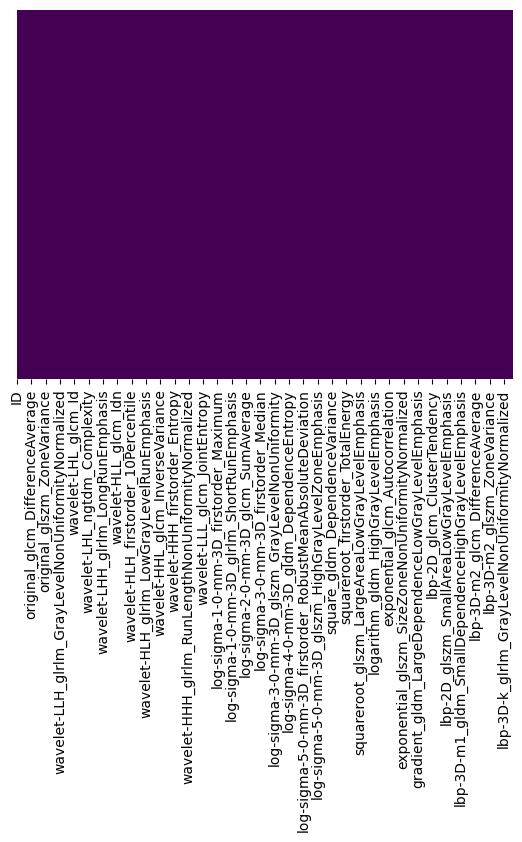

In [21]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

## Diagnostic Exploration

In [22]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [23]:
diagnostics_configs(control_df)
diagnostics_configs(train_df)

1
1
1
1


In [24]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [25]:
diagnostics_versions_explorer(control_df)
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']
diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [26]:
diagnostics_image_columns = ["diagnostics_Image-original_Mean","diagnostics_Image-original_Minimum","diagnostics_Image-original_Maximum"]
def diagnostics_image_explorer(df):

    for column in diagnostics_image_columns:
        show_histogram(df=df[column],title=column)

    explore_outliers(df,diagnostics_image_columns)

    print(df[diagnostics_image_columns].describe())
    print(df[diagnostics_image_columns].info())
    

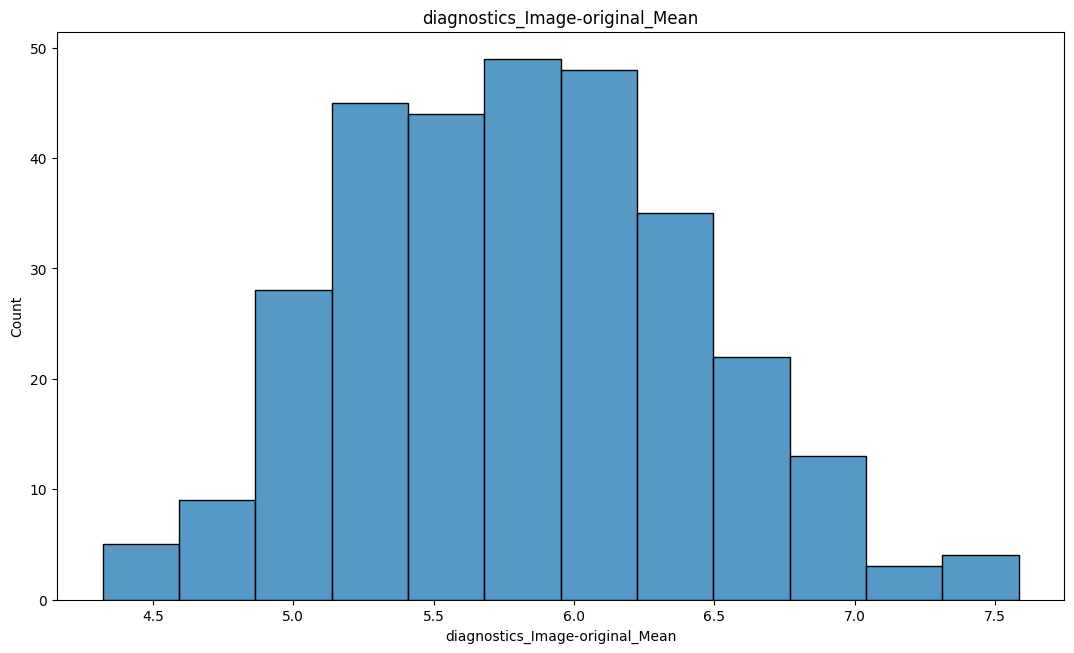

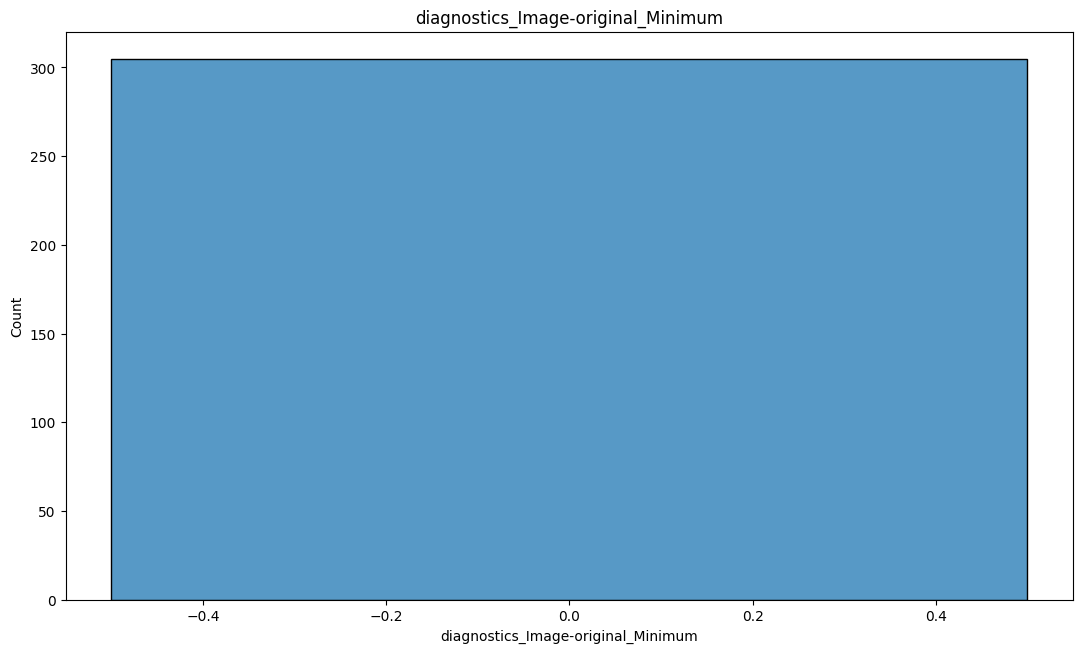

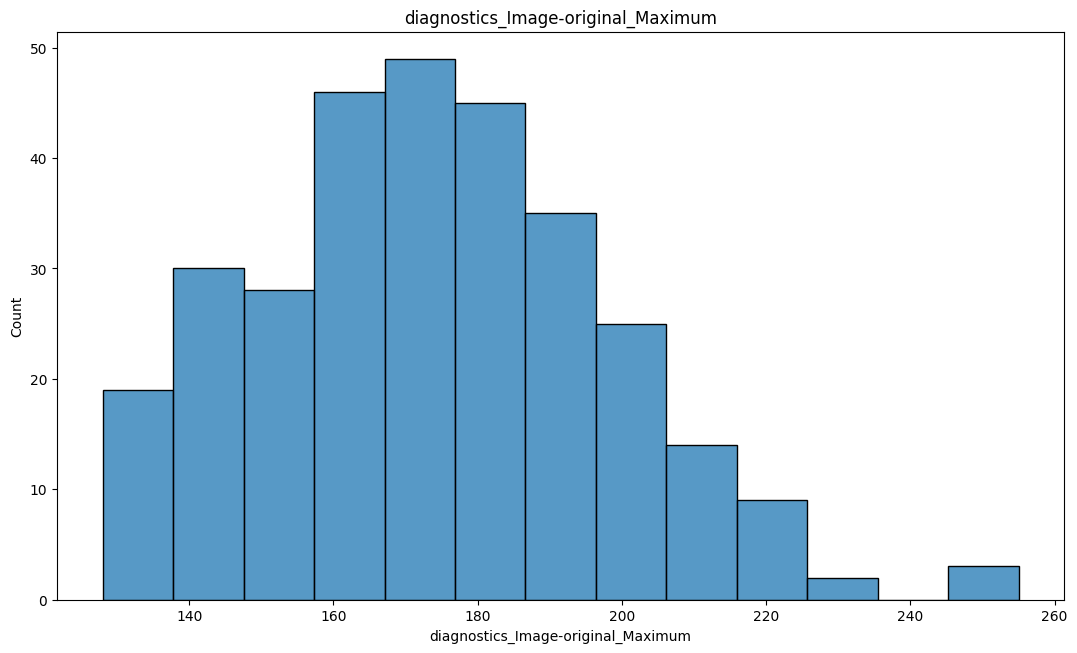

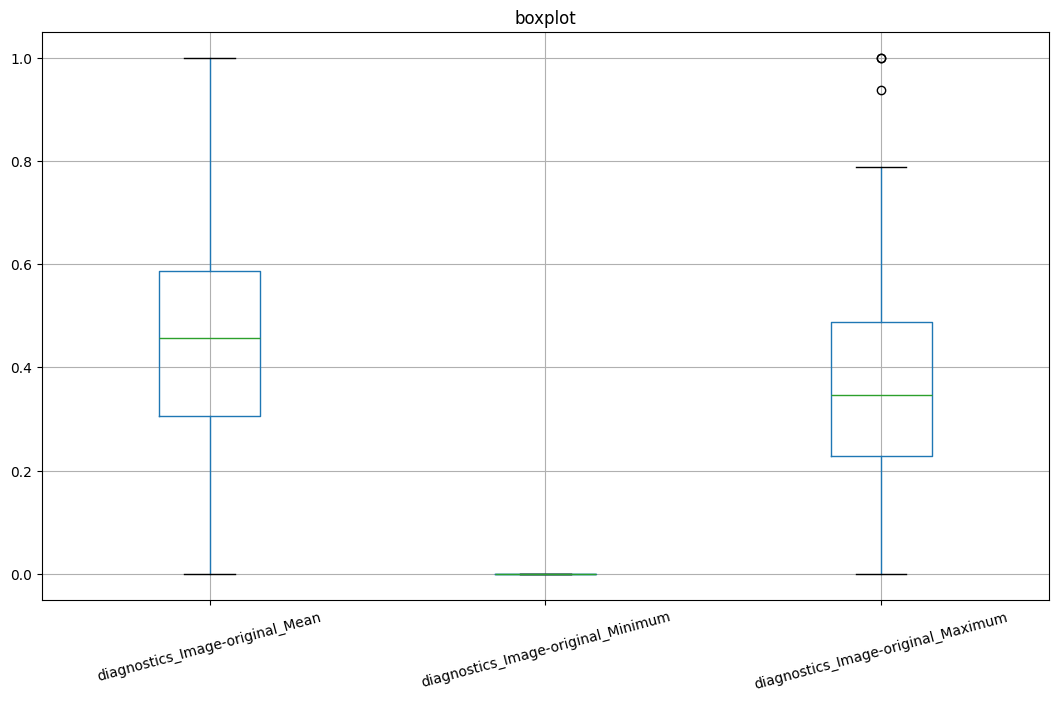

       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                       305.000000                               305.0   
mean                          5.810469                                 0.0   
std                           0.613858                                 0.0   
min                           4.321602                                 0.0   
25%                           5.317298                                 0.0   
50%                           5.811449                                 0.0   
75%                           6.237751                                 0.0   
max                           7.583210                                 0.0   

       diagnostics_Image-original_Maximum  
count                          305.000000  
mean                           173.504918  
std                             24.108871  
min                            128.000000  
25%                            157.000000  
50%                            17

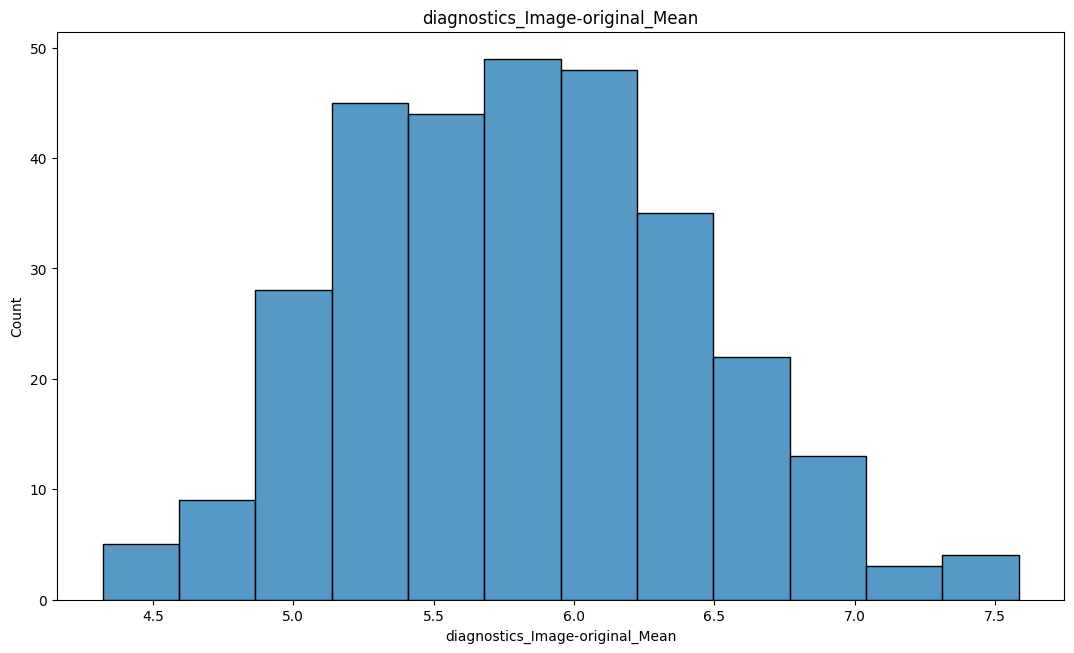

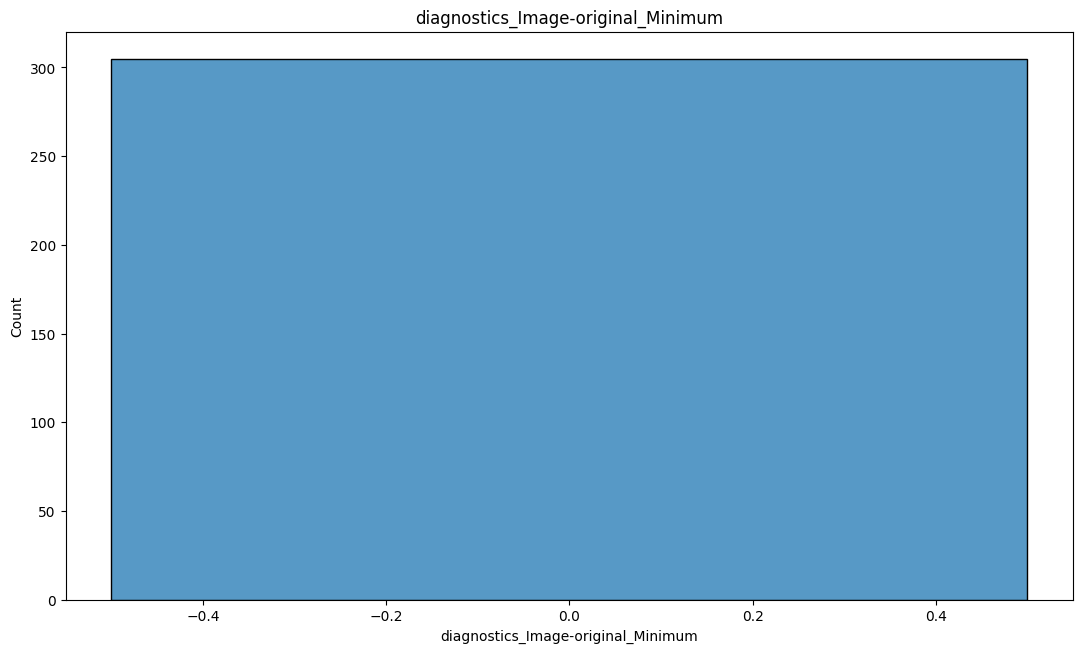

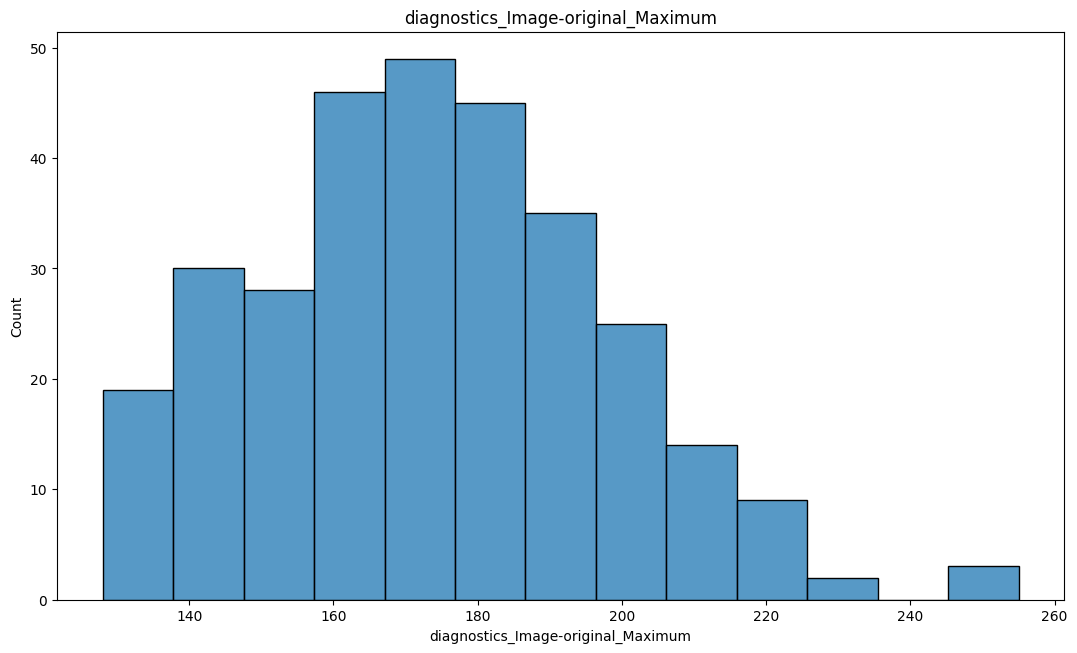

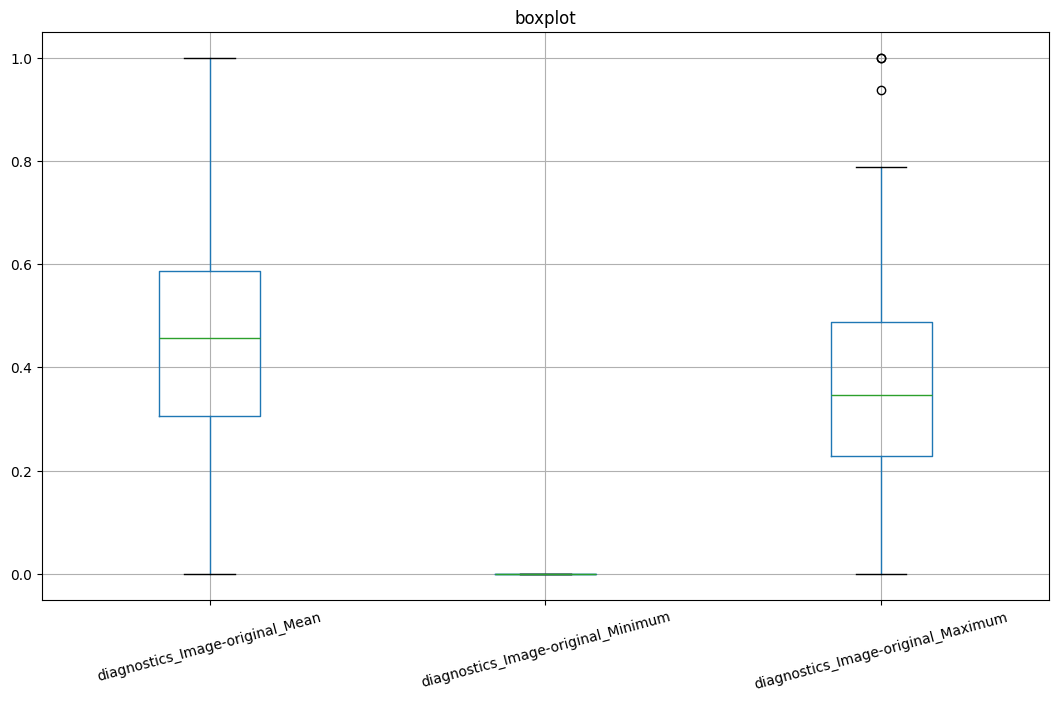

       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                       305.000000                               305.0   
mean                          5.810469                                 0.0   
std                           0.613858                                 0.0   
min                           4.321602                                 0.0   
25%                           5.317298                                 0.0   
50%                           5.811449                                 0.0   
75%                           6.237751                                 0.0   
max                           7.583210                                 0.0   

       diagnostics_Image-original_Maximum  
count                          305.000000  
mean                           173.504918  
std                             24.108871  
min                            128.000000  
25%                            157.000000  
50%                            17

In [27]:
diagnostics_image_explorer(control_df)
diagnostics_image_explorer(train_df)

In [28]:
diagnostics_mask_columns = ["diagnostics_Mask-original_BoundingBox","diagnostics_Mask-original_VoxelNum","diagnostics_Mask-original_VolumeNum","diagnostics_Mask-original_CenterOfMassIndex","diagnostics_Mask-original_CenterOfMass"]
def diagnostics_mask_explorer(df):

    
    for column in diagnostics_mask_columns:
        print(column,": ")
        values = df[column].unique()
        print(len(values))
        show_histogram(title=column,df=df[column])
    

    detect_outliers(df,"diagnostics_Mask-original_VoxelNum")
    detect_outliers(df,"diagnostics_Mask-original_VolumeNum")
    explore_outliers(df,columns=diagnostics_mask_columns)
    
    print(df[diagnostics_mask_columns].describe(),"\n")
    print(df[diagnostics_mask_columns].info())

diagnostics_Mask-original_BoundingBox : 
305


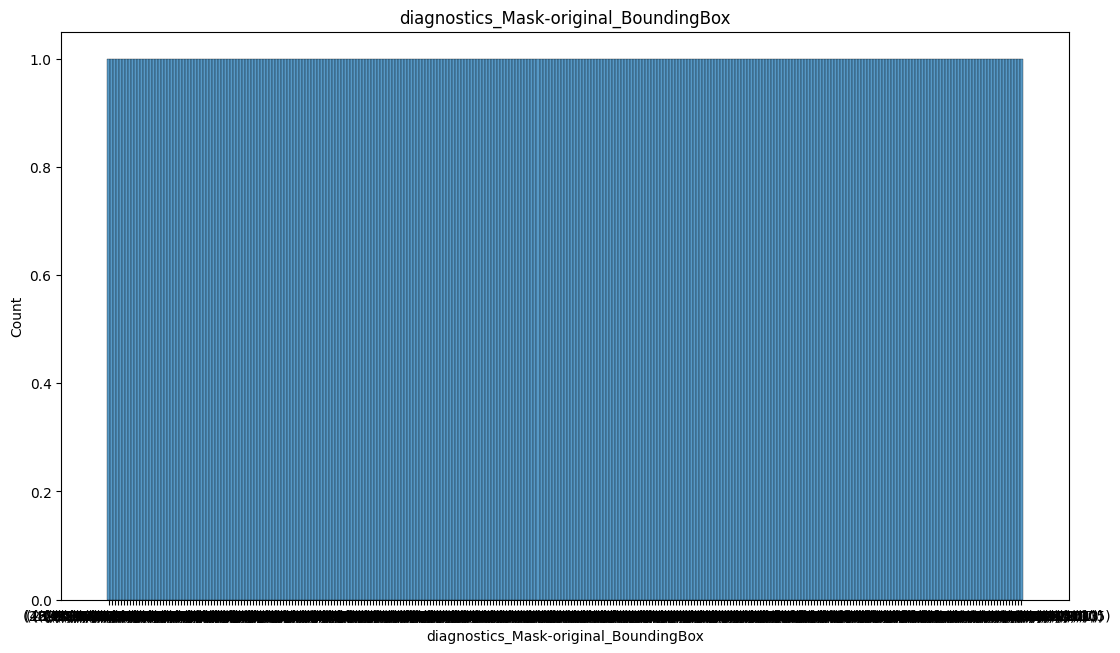

diagnostics_Mask-original_VoxelNum : 
300


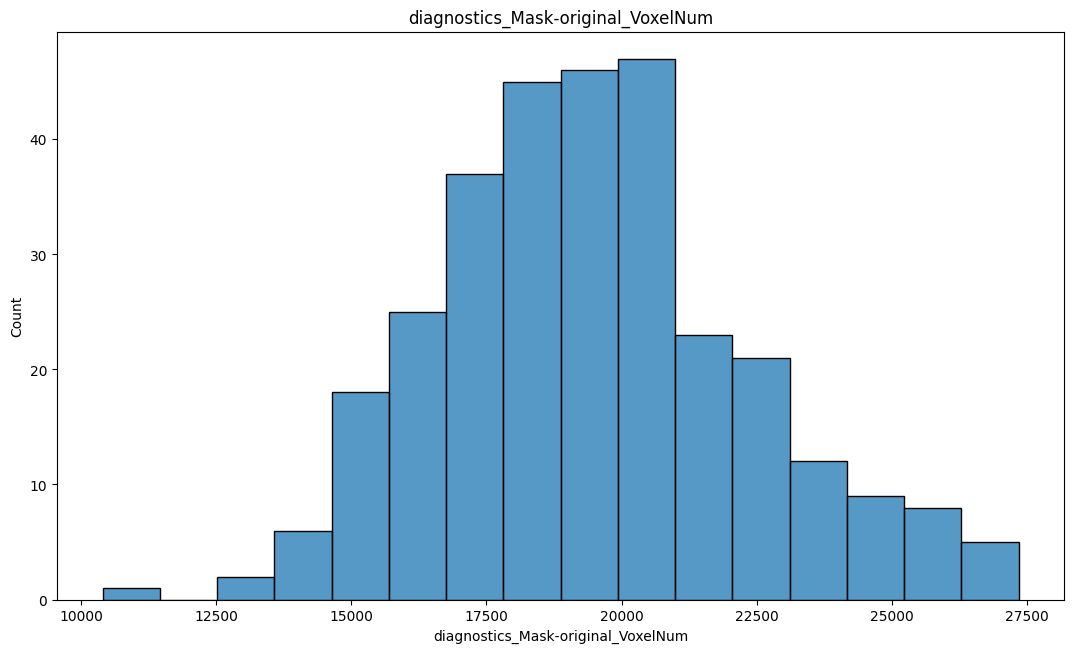

diagnostics_Mask-original_VolumeNum : 
4


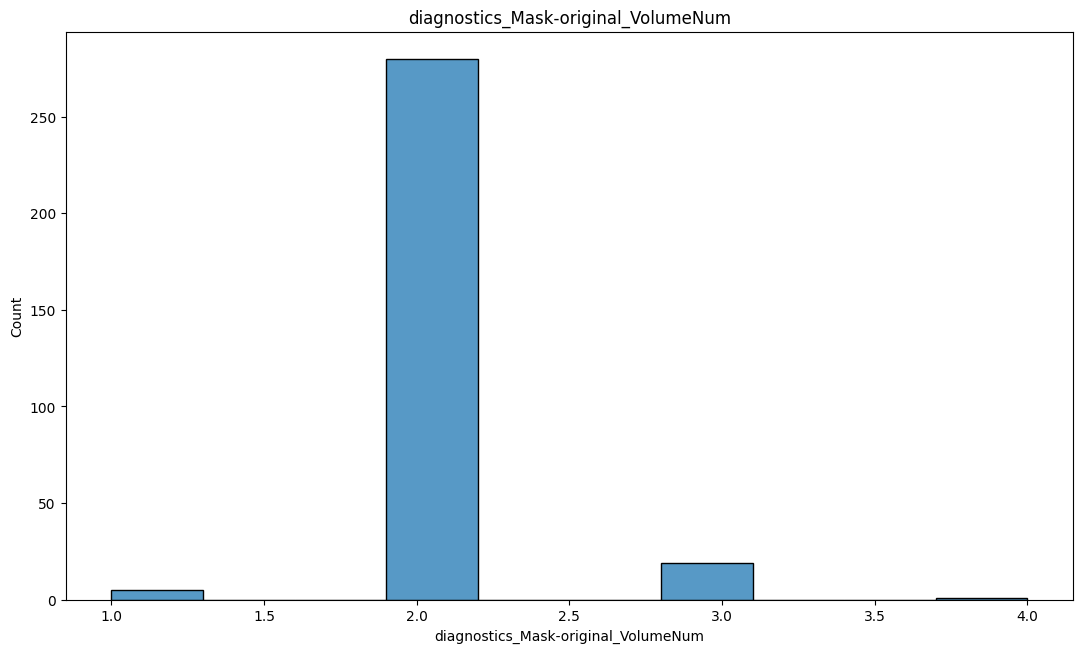

diagnostics_Mask-original_CenterOfMassIndex : 
305


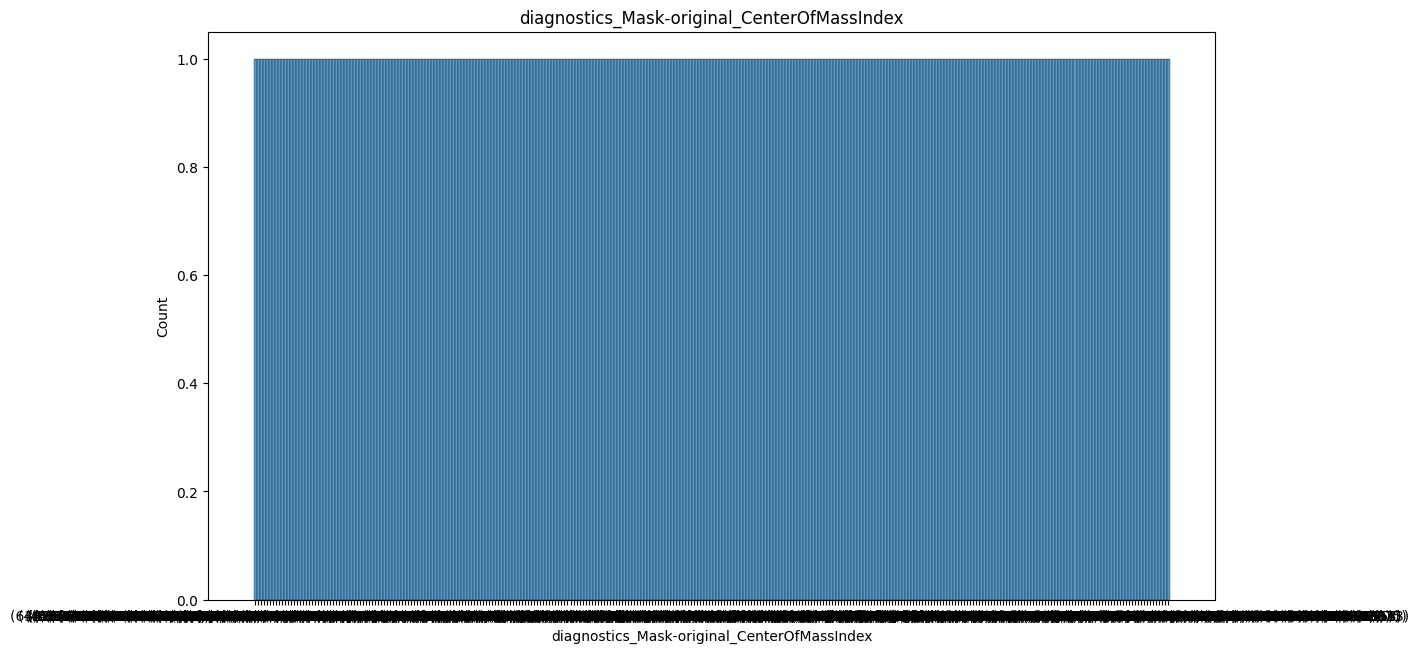

diagnostics_Mask-original_CenterOfMass : 
305


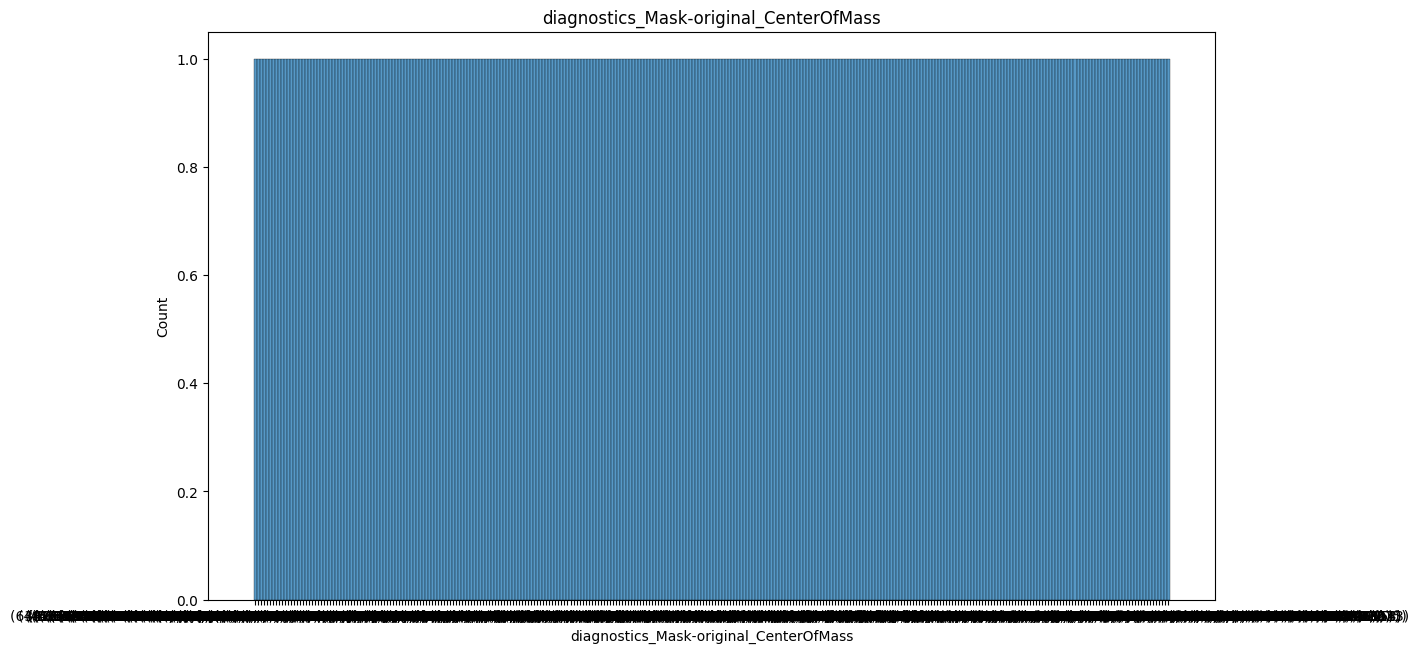

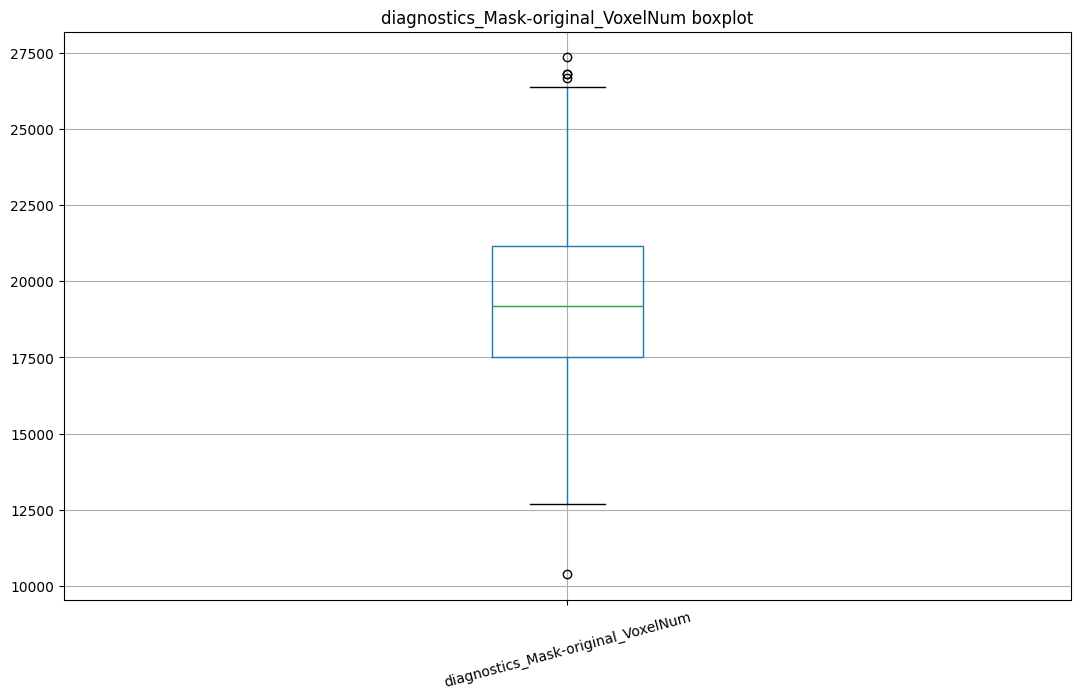

58     26802
109    26668
153    27345
156    26813
174    10400
Name: diagnostics_Mask-original_VoxelNum, dtype: int64


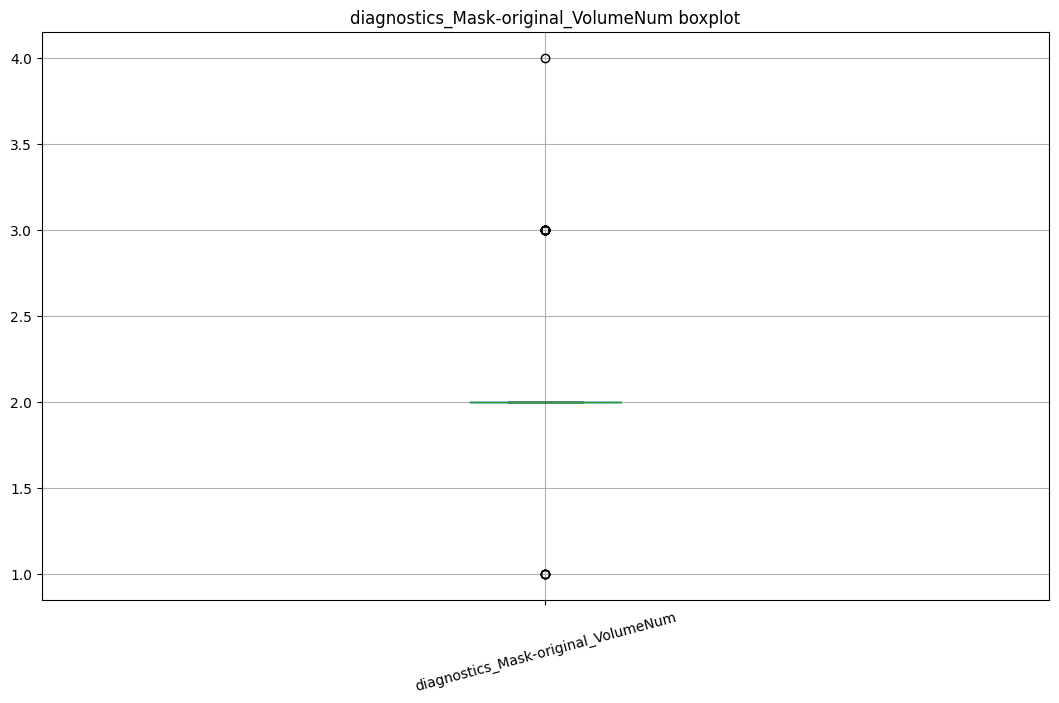

2      4
28     3
38     3
41     3
45     3
59     3
73     1
83     1
89     3
98     3
101    3
112    3
114    1
131    3
141    3
144    1
147    1
148    3
151    3
163    3
230    3
244    3
262    3
274    3
298    3
Name: diagnostics_Mask-original_VolumeNum, dtype: int64


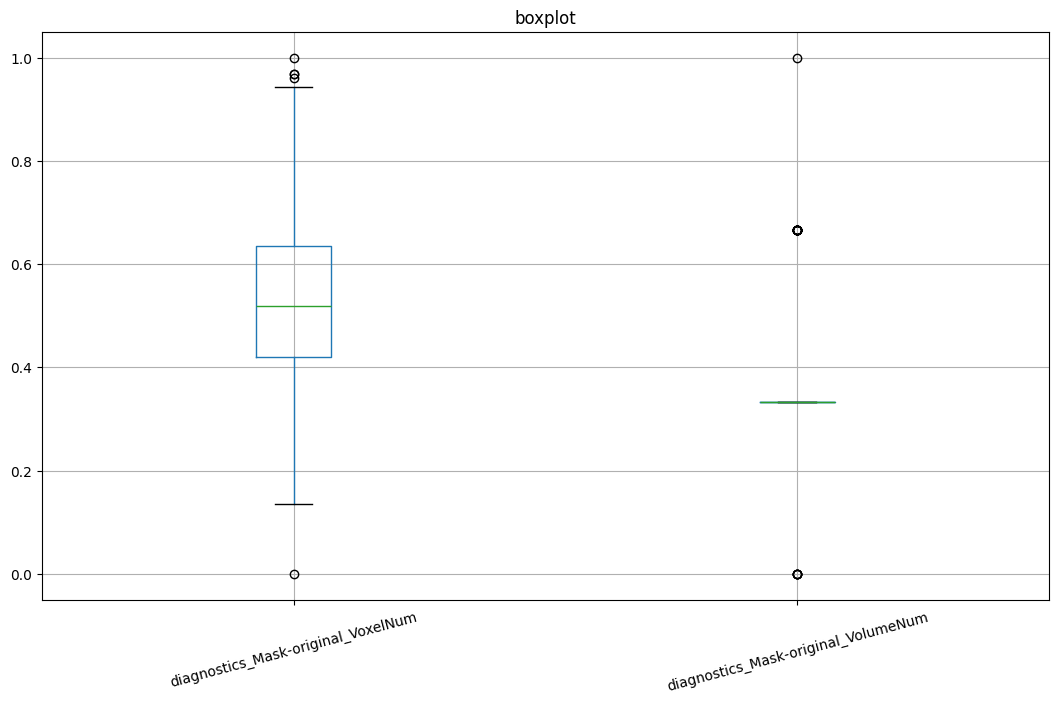

       diagnostics_Mask-original_VoxelNum  diagnostics_Mask-original_VolumeNum
count                          305.000000                           305.000000
mean                         19466.340984                             2.052459
std                           2897.483977                             0.298905
min                          10400.000000                             1.000000
25%                          17521.000000                             2.000000
50%                          19201.000000                             2.000000
75%                          21155.000000                             2.000000
max                          27345.000000                             4.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   diagnostics_Mask-original_Boundi

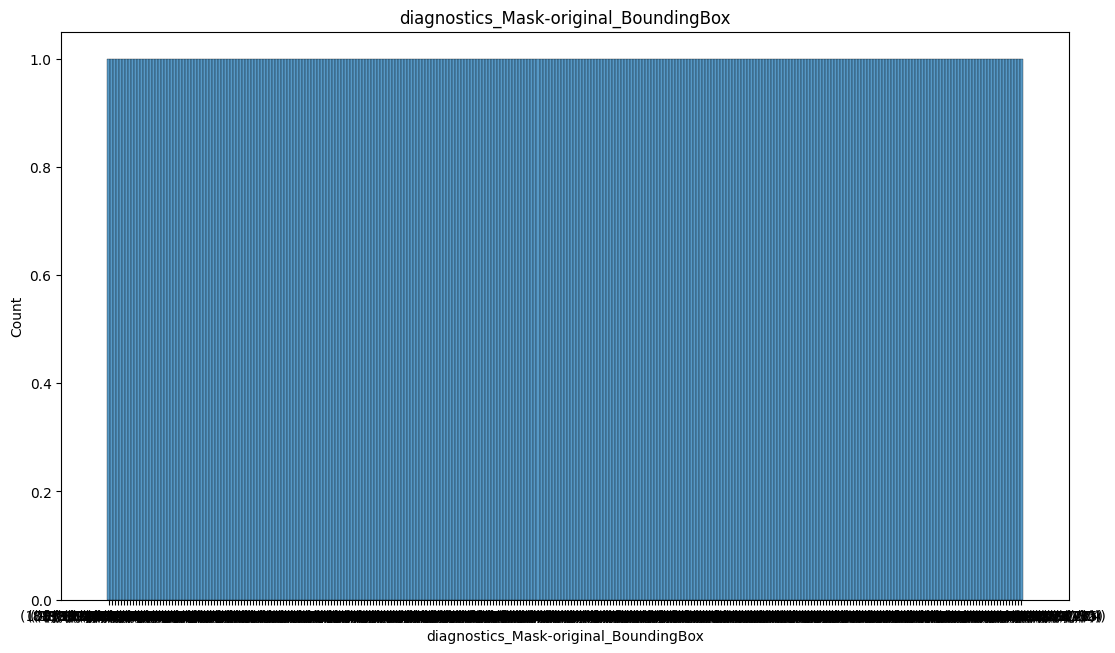

diagnostics_Mask-original_VoxelNum : 
294


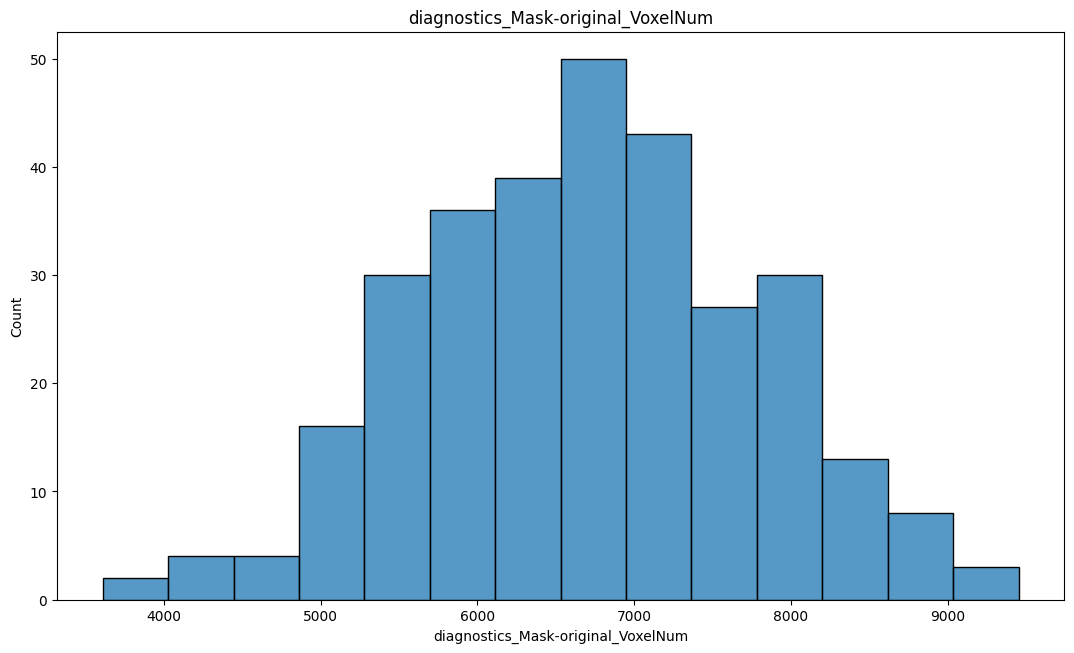

diagnostics_Mask-original_VolumeNum : 
1


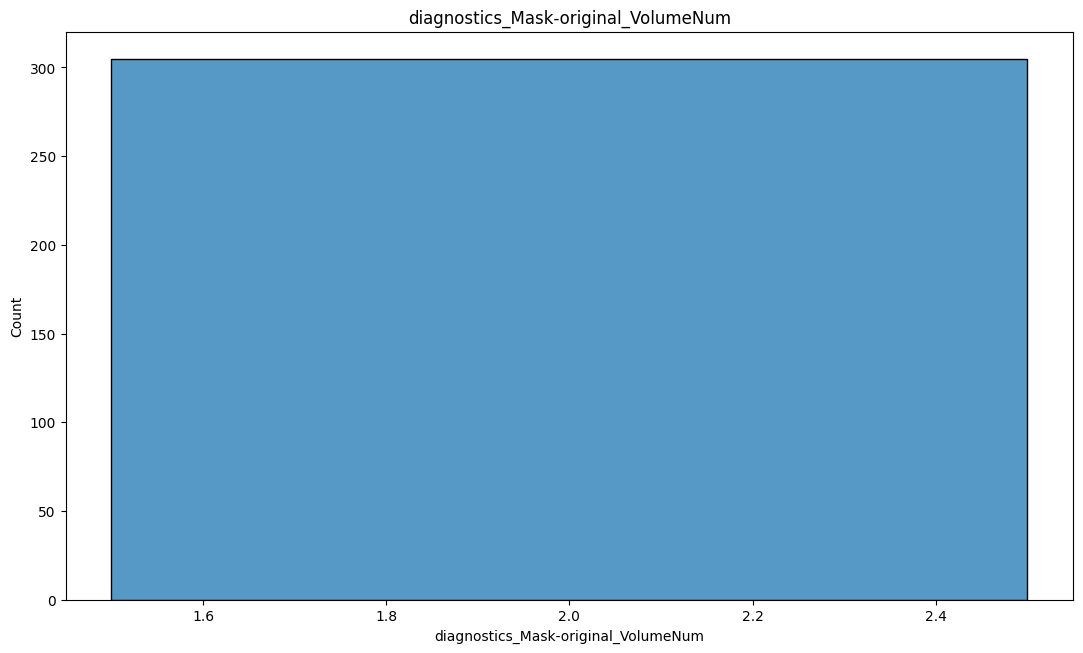

diagnostics_Mask-original_CenterOfMassIndex : 
305


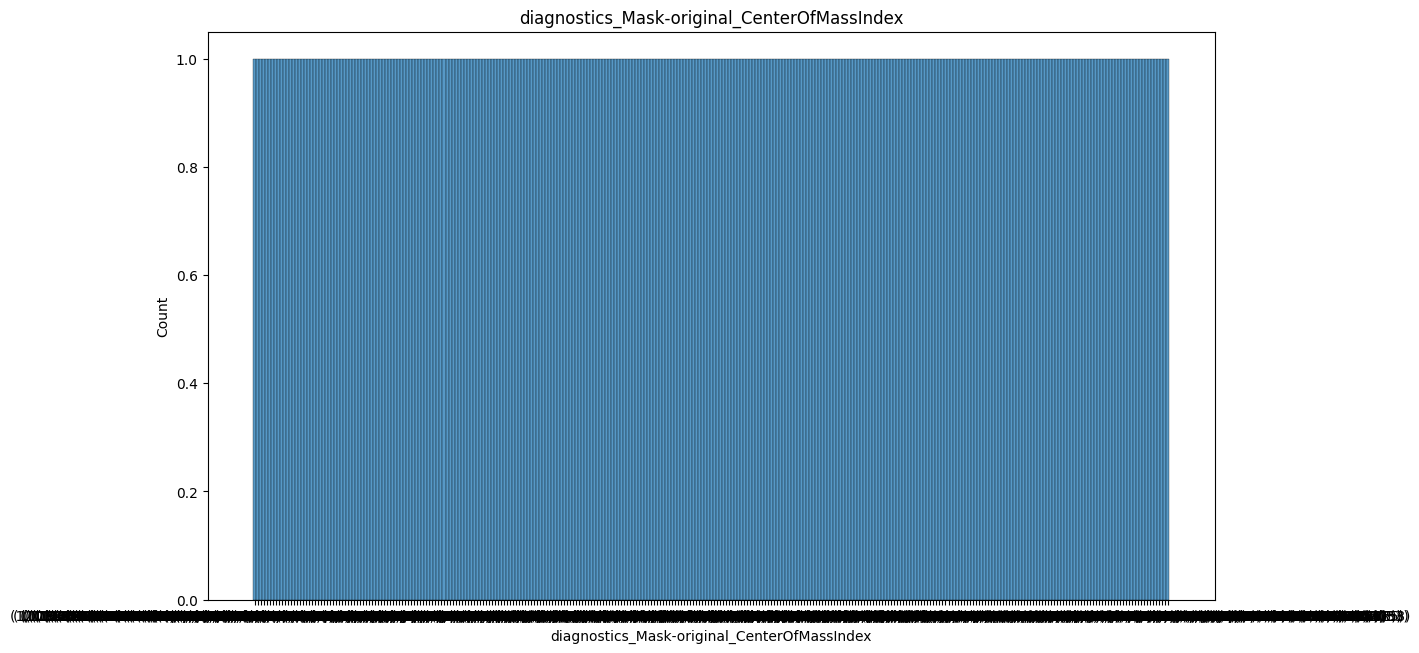

diagnostics_Mask-original_CenterOfMass : 
305


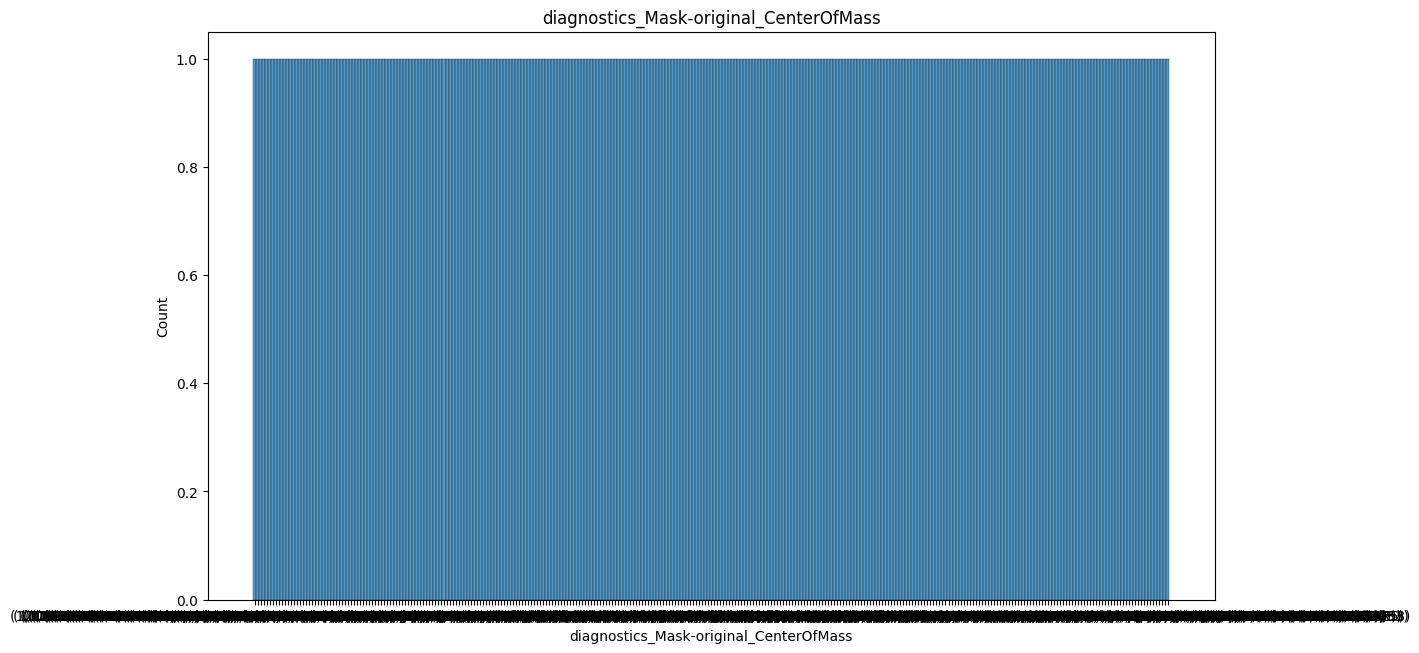

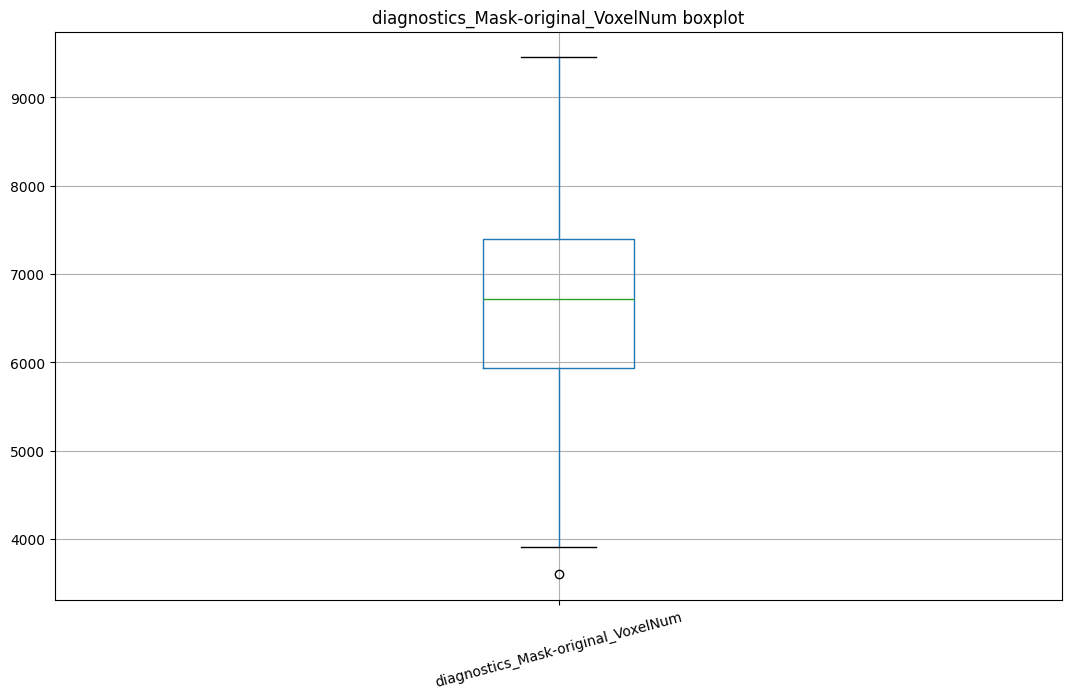

188    3609
Name: diagnostics_Mask-original_VoxelNum, dtype: int64


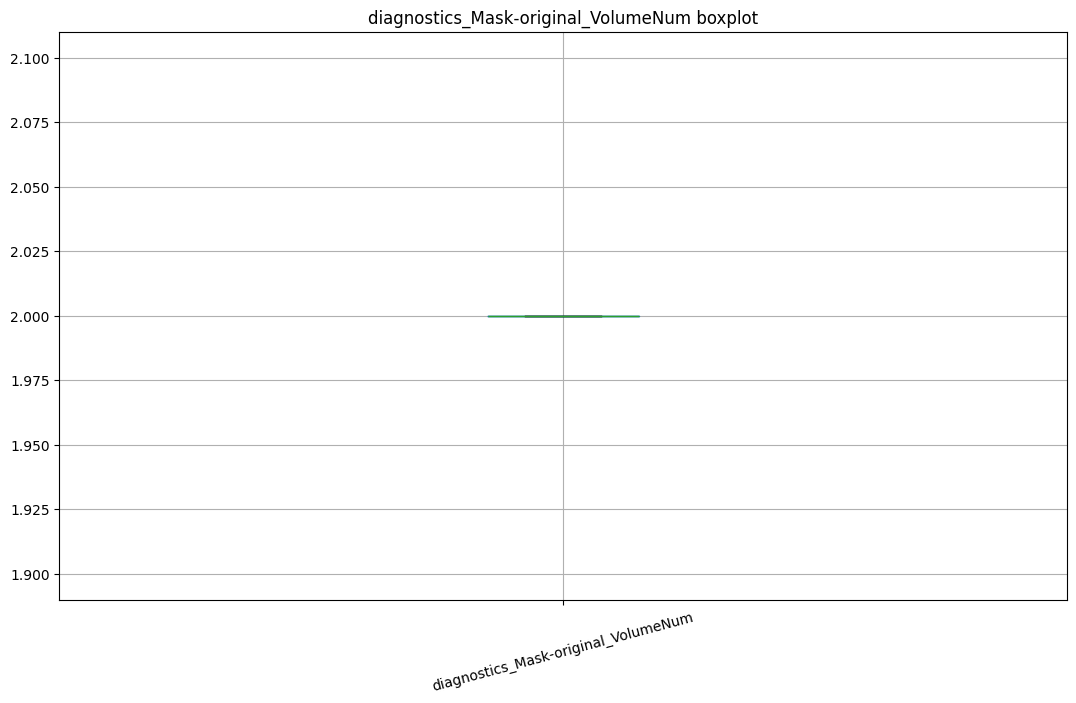

Series([], Name: diagnostics_Mask-original_VolumeNum, dtype: int64)


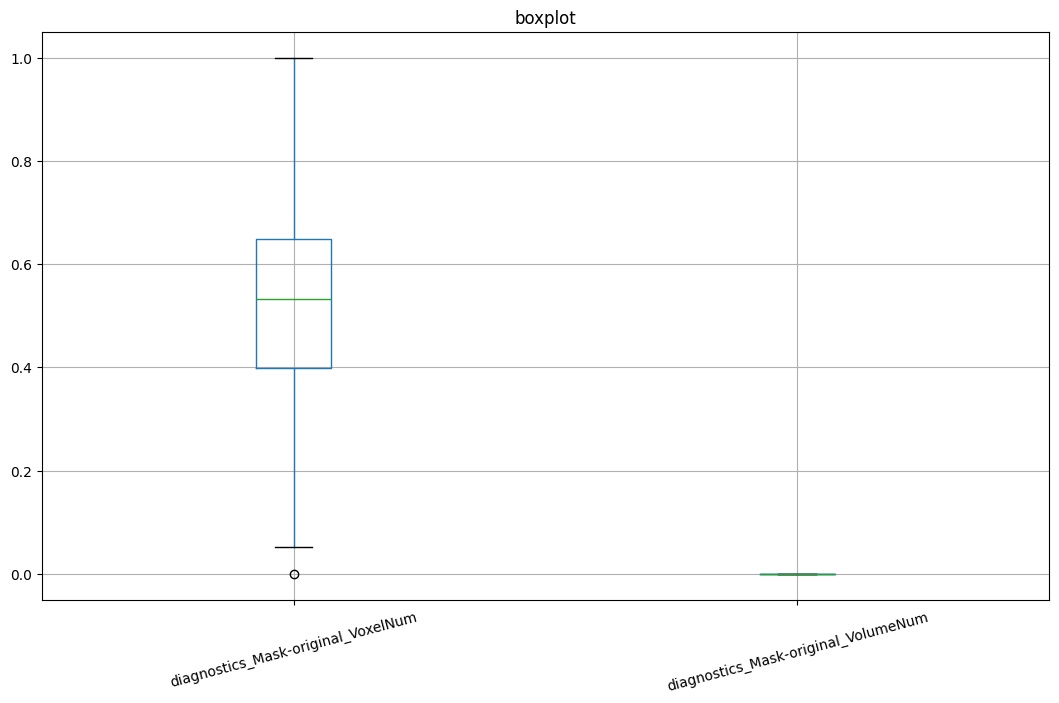

       diagnostics_Mask-original_VoxelNum  diagnostics_Mask-original_VolumeNum
count                          305.000000                                305.0
mean                          6714.790164                                  2.0
std                           1066.815670                                  0.0
min                           3609.000000                                  2.0
25%                           5941.000000                                  2.0
50%                           6723.000000                                  2.0
75%                           7396.000000                                  2.0
max                           9453.000000                                  2.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   diagnostics_Mask-original_Boundi

In [29]:
diagnostics_mask_explorer(control_df)
diagnostics_mask_explorer(train_df)

In [30]:
diagnostics = ["diagnostics_Mask-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Mask-original_BoundingBox","diagnostics_Mask-original_VoxelNum","diagnostics_Mask-original_VolumeNum","diagnostics_Mask-original_CenterOfMassIndex","diagnostics_Mask-original_CenterOfMass","diagnostics_Image-original_Spacing","diagnostics_Image-original_Size","diagnostics_Image-original_Mean","diagnostics_Image-original_Maximum"]
def masks_images_correlation(df):
    show_heatmap(df=df[diagnostics])   

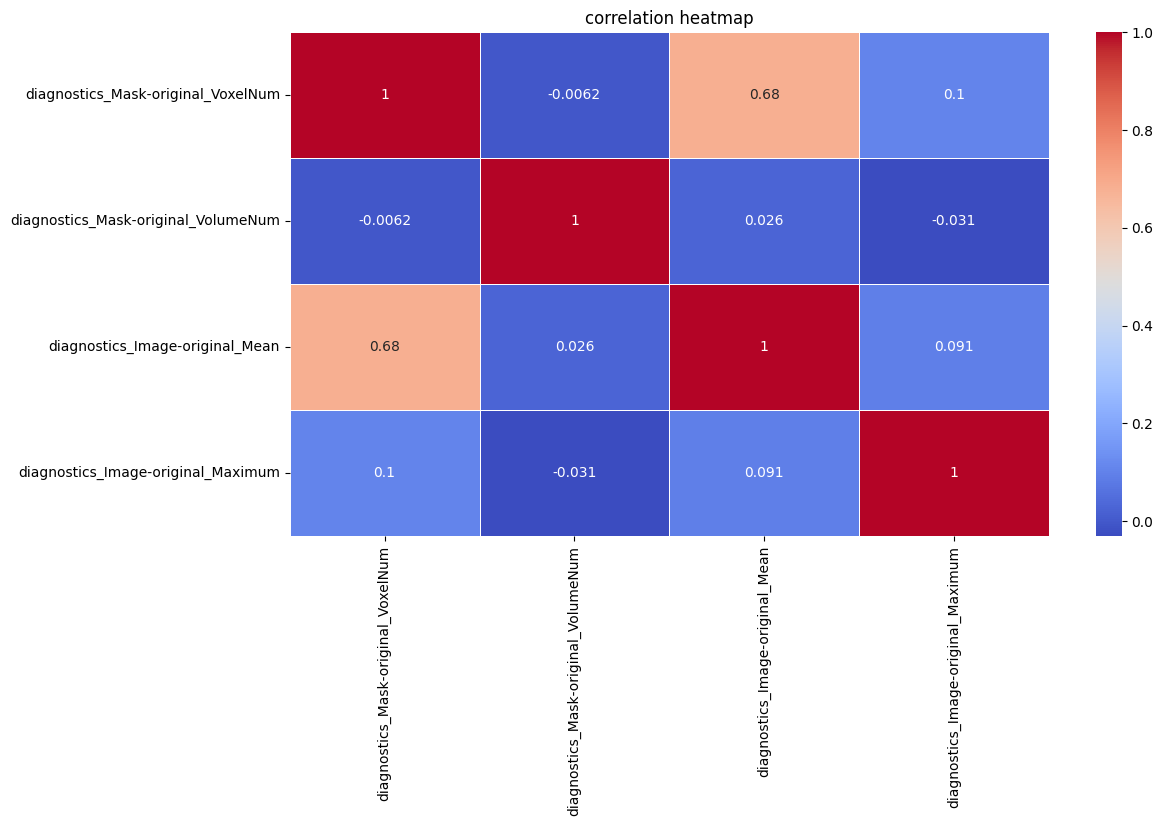

In [31]:
masks_images_correlation(control_df)

## Drop Unnecessary Columns

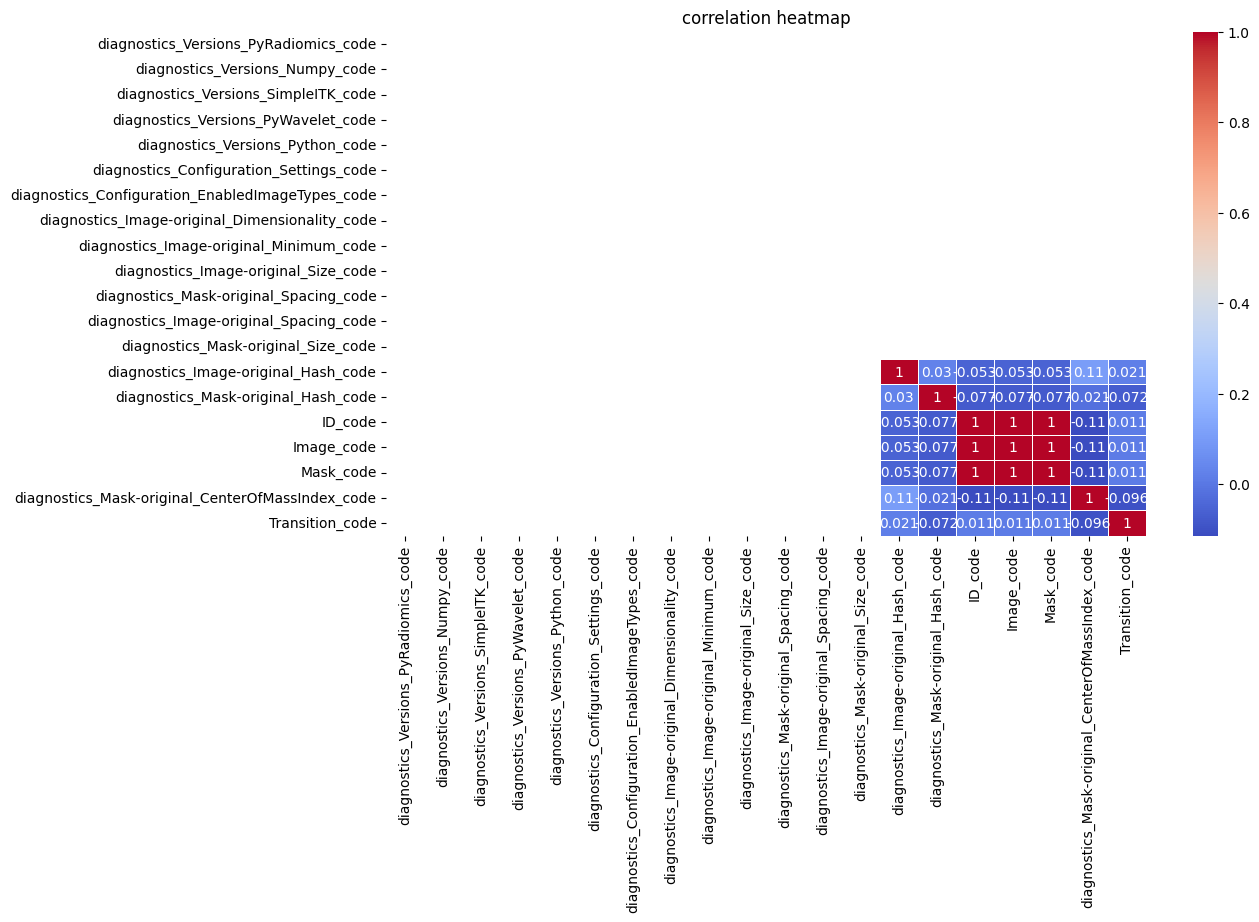

In [32]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

In [33]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

In [34]:
main_exploration(train_df)

(305, 2163)


## Top Correlations Function
Esta função devolve as colunas mais/menos correlacionadas com a feature target desejada

In [35]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

corr_columns = train_df.select_dtypes(include=["int64","float64"]).columns
corr_matrix = train_df[corr_columns].corrwith(train_df["Transition_code"])


C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Nunique Columns PreProcessing

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


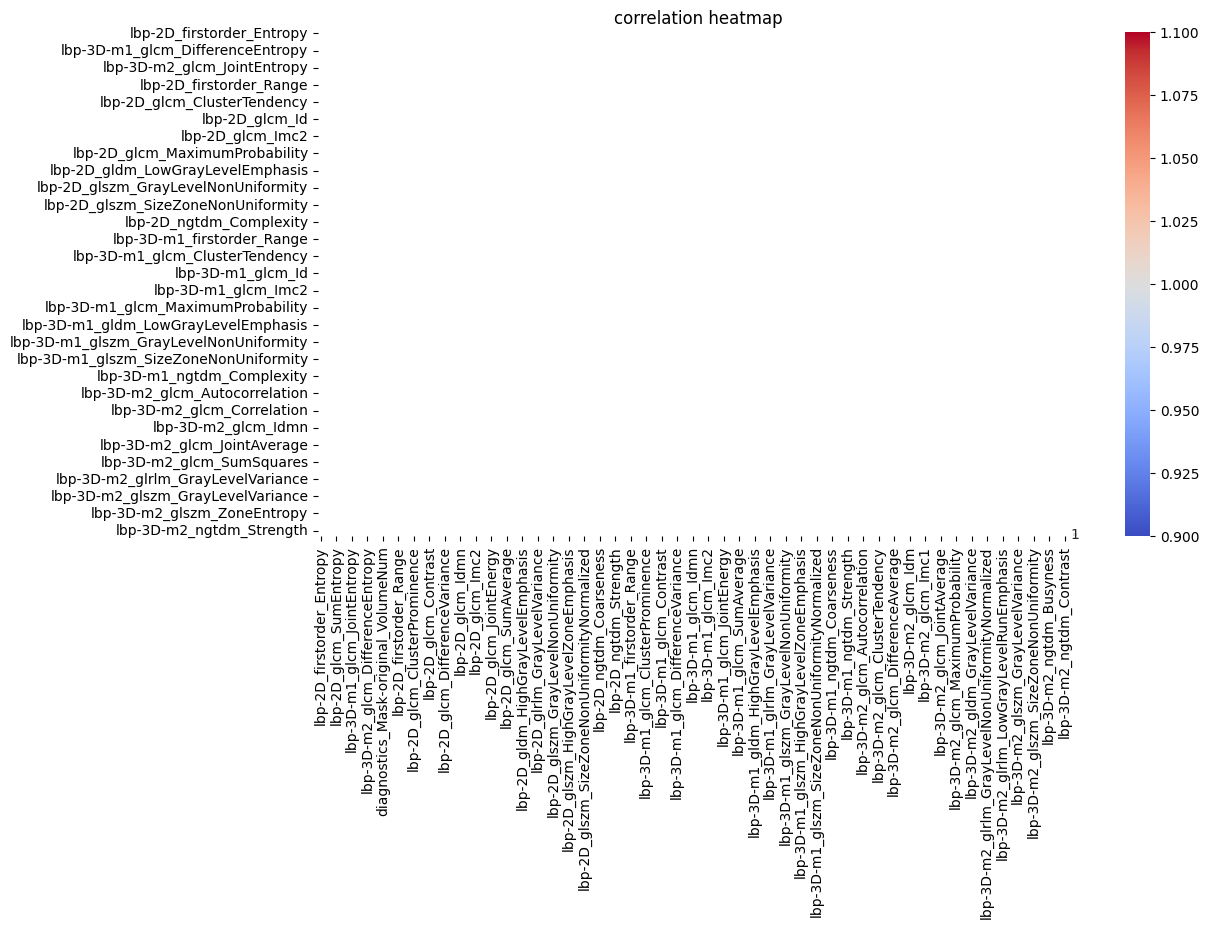

(305, 2163)
(305, 2163)
(100, 2161)


In [36]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
nunique_columns.append("Transition_code")
nunique_corr_columns = top_correlations(train_df[nunique_columns],number=10000)

show_heatmap(train_df[nunique_corr_columns])

main_exploration(train_df)
main_exploration(control_df)
main_exploration(test_df)

nunique_columns.remove("Transition_code")
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")


## Non Numeric Exploration

In [37]:
def non_numeric_exploration(df):
    non_numeric_columns = train_df.select_dtypes(exclude=['int64', 'float64']).columns
    return non_numeric_columns

In [38]:
non_numeric_columns = non_numeric_exploration(train_df)
print(train_df[non_numeric_columns].head())

  diagnostics_Mask-original_BoundingBox  \
0            (103, 113, 93, 36, 30, 71)   
1             (81, 127, 93, 47, 16, 73)   
2             (77, 119, 89, 49, 30, 81)   
3             (93, 102, 90, 41, 29, 78)   
4             (87, 119, 91, 40, 27, 75)   

              diagnostics_Mask-original_CenterOfMass Transition  \
0  (121.94230227976358, 129.27272727272728, 128.4...      CN-CN   
1  (107.06170458927883, 135.28088443244633, 128.2...      CN-CN   
2  (103.3640972118682, 135.28164604144922, 128.98...      AD-AD   
3  (116.29827315541601, 118.67431469629271, 129.3...     CN-MCI   
4  (108.26561977948546, 132.05462746408287, 127.6...      CN-CN   

   Transition_code  
0                1  
1                1  
2                0  
3                2  
4                1  


## Non Numerical Columns PreProcessing

In [53]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

In [54]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

KeyError: 'diagnostics_Mask-original_BoundingBox'

In [ ]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [ ]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [55]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

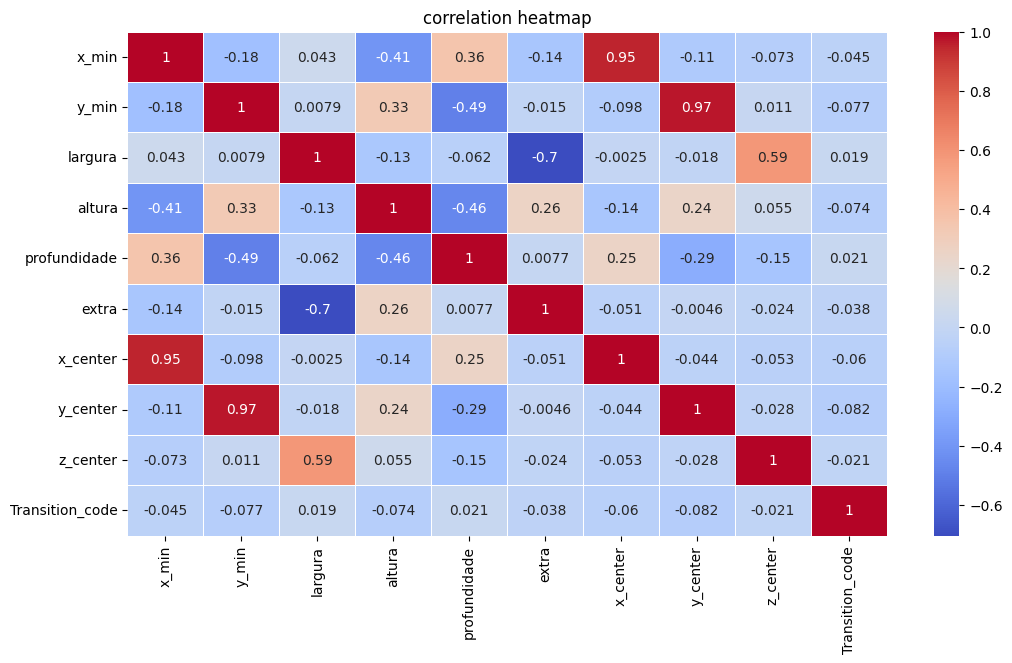

In [56]:
new_numeric_columns = ['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra','x_center', 'y_center', 'z_center',"Transition_code"]
show_heatmap(train_df[new_numeric_columns])


## Numeric Diagnostics Corr

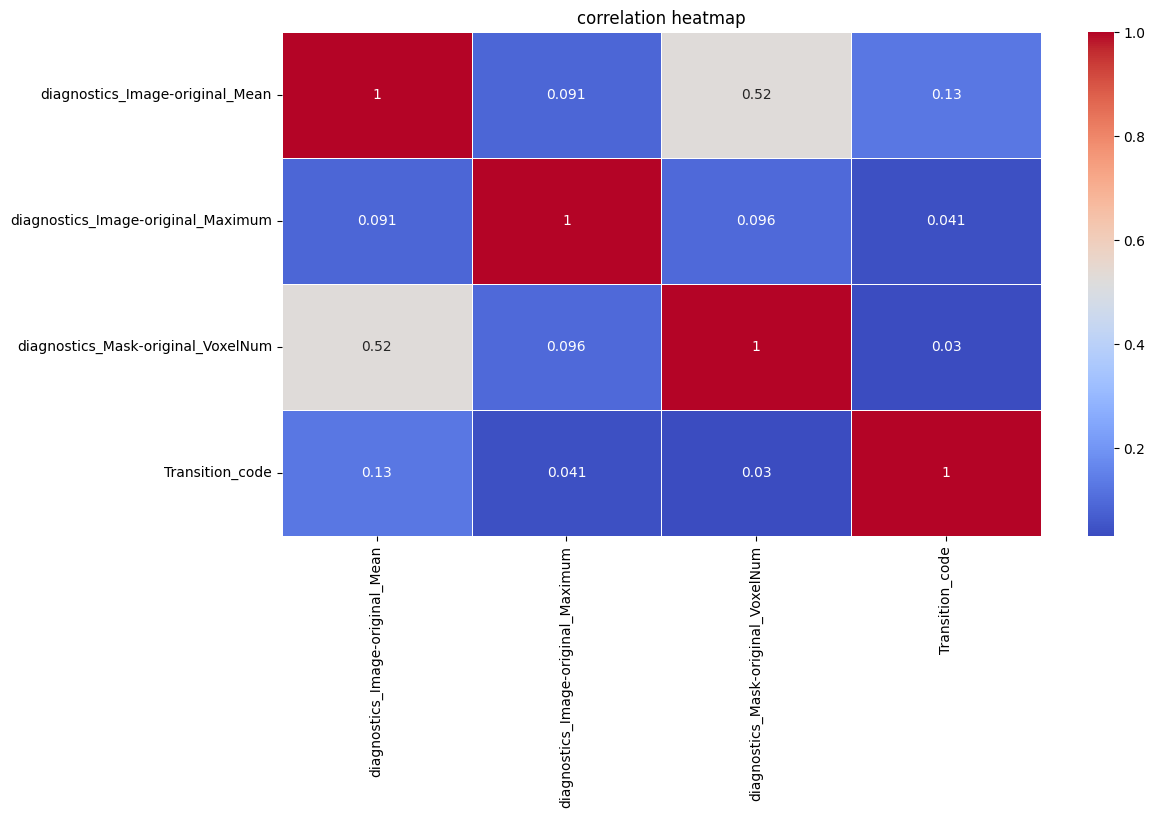

In [57]:
diagnostics_corr = top_correlations(train_df, starts_with="diagnostics")
show_heatmap(train_df[diagnostics_corr])

## Radiomics

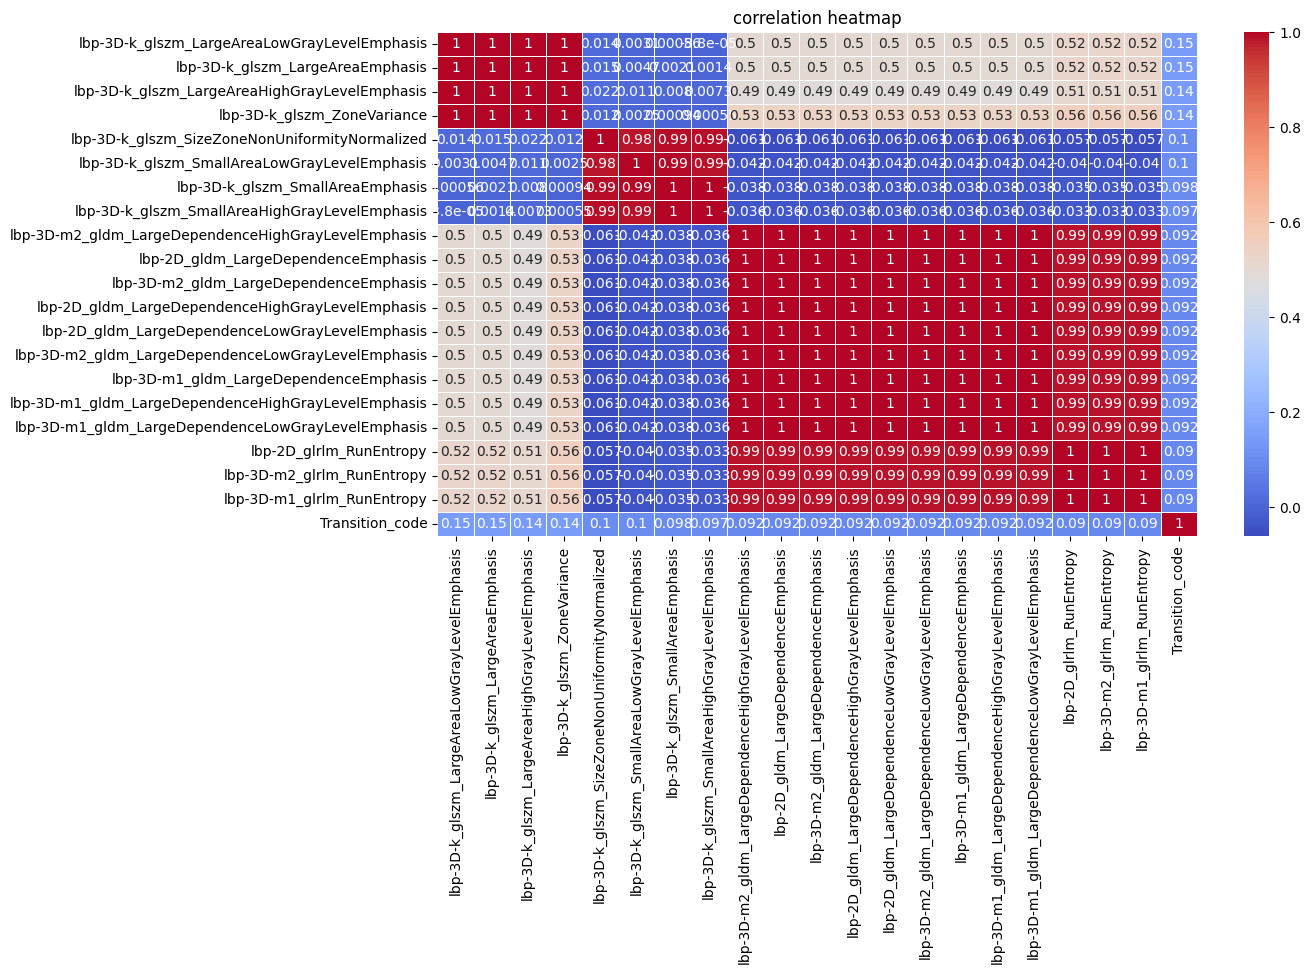

In [58]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

## Top Correlations
Retorna as X colunas com melhor correlação com o nosso target

In [59]:
top_features = top_correlations(train_df)
#show_heatmap(train_df[top_features])

# Data Processing

## Data Scaler
Padroniza os dados

In [60]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [61]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

## Data Normalizer
Normalizar dados

In [ ]:
main_exploration(test_df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def data_normalizer(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(scaler_df), columns=scaler_df.columns)
    
    return df_normalized

In [65]:
normalized_train_df = data_normalizer(train_df)
normalized_control_df = data_normalizer(control_df)
normalized_test_df = data_normalizer(test_df)


NameError: name 'data_normalizer' is not defined

In [66]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"


## Correlation Analisys

In [67]:
corr_threshold = 0.01
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features


In [68]:
corr_important_features = apply_correlation(corr_df,corr_threshold)
print(len(corr_important_features))

1782


In [ ]:
corr_train_df = scaled_train_df[corr_important_features].copy()
corr_control_df = scaled_control_df[corr_important_features].copy()
corr_test_df = scaled_test_df[corr_important_features].copy()

In [ ]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

In [ ]:
print("Important: ",len(corr_important_features))

## Add Transition_code to DataSets

In [ ]:
corr_train_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
corr_control_df.loc[:,"Transition_code"] = control_df["Transition_code"].values

In [ ]:
#show_boxplot(corr_train_df)

# Testing Phase

## ML Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier

In [ ]:
def define_X_y(train_df, test_df = pd.DataFrame()):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=27)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [ ]:
grid_search_mode = True

random_forest_params = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
xgb_params = {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
gradient_params = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}

corr_threshold = np.nan
shap_threshold = np.nan
results = {}

In [ ]:
x_train, x_test, y_train, y_test = define_X_y(corr_train_df)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(len(x_train[1]))
main_exploration(x_train)
main_exploration(x_test)

### Random Forest w/ GridSearch Cross Validation

In [ ]:
def random_forest(x_train, y_train, best_params=None, mode=False):
    random_forest = RandomForestClassifier(random_state=27, class_weight='balanced', max_samples=0.8,n_jobs=-1)

    if best_params is not None:
        random_forest.set_params(**best_params)
    if mode:
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt']
        }
        
        grid_search_random = RandomizedSearchCV(
            estimator=random_forest,
            param_distributions=param_grid,
            n_iter=60,
            cv=5,
            scoring='f1_macro',
            n_jobs=-1,
            random_state=27
        )

        grid_search_random.fit(x_train, y_train)
        best_params = grid_search_random.best_params_
        print(f"Melhores parâmetros: {best_params}")
        
        random_forest = grid_search_random.best_estimator_

    random_forest.fit(x_train, y_train)


    return random_forest, best_params


In [ ]:
random_forest_model, random_forest_params = random_forest(x_train, y_train,best_params=random_forest_params,mode=grid_search_mode)

In [ ]:
results["RandomForest"] = [random_forest_model,None]

### XGBoost w/ GridSearch Cross Validation

In [ ]:
def xgboost_model(x_train, y_train, best_params=None, mode=False):
    xgb_model = XGBClassifier(eval_metric="mlogloss", random_state=27,n_jobs=-1)

    if best_params is not None:
        xgb_model.set_params(**best_params)
    if mode:
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        grid_search_random = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_grid,
            n_iter=20,
            cv=4,
            scoring='f1_macro',
            n_jobs=-1,
            random_state=27
        )

        grid_search_random.fit(x_train, y_train)
        best_params = grid_search_random.best_params_
        print(f"Melhores parâmetros: {best_params}")
        
        xgb_model = grid_search_random.best_estimator_

    xgb_model.fit(x_train, y_train)
    return xgb_model, best_params


In [ ]:
xgb_model,xgb_params = xgboost_model(x_train, y_train,best_params=xgb_params,mode=grid_search_mode)

In [ ]:
results["XGBoost"] = [xgb_model,None]

### Gradient Boost w/ GridSearch Cross Validation

In [ ]:
def gradient_boosting(x_train, y_train, best_params=None, mode=False):
    gradient_boosting = GradientBoostingClassifier(random_state=27)

    if best_params is not None:
        gradient_boosting.set_params(**best_params)
            
    if mode:
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        grid_search_random = RandomizedSearchCV(
            estimator=gradient_boosting,
            param_distributions=param_grid,
            n_iter=20,
            cv=4,
            scoring='f1_macro',
            n_jobs=-1,
            random_state=27
        )
        
        grid_search_random.fit(x_train, y_train)
        best_params = grid_search_random.best_params_
        print(f"Melhores parâmetros: {best_params}")
        
        gradient_boosting = grid_search_random.best_estimator_

    gradient_boosting.fit(x_train, y_train)
    return gradient_boosting, best_params


In [ ]:
gradient_model,gradient_params = gradient_boosting(x_train, y_train,best_params=gradient_params,mode=grid_search_mode)

In [ ]:
results["GradientBoost"] = [gradient_model,None]

In [ ]:
models_comparison(results)

## Ensemble Learning (RandomForest w/ XGBoost)

### Voting Classifier

In [ ]:
calibrated_rf = CalibratedClassifierCV(random_forest_model, method='sigmoid', cv=4)
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=4)
calibrated_gradient = CalibratedClassifierCV(gradient_model, method='sigmoid', cv=4)

In [ ]:
def ensemble_voting_classifier(x_train, y_train):
    ensemble_model_v = VotingClassifier(
        estimators=[
            ("random_forest", calibrated_rf),
            ("xgboost", calibrated_xgb),
            ("gradientboost", calibrated_gradient),
        ],
        voting="soft",
        n_jobs=-1
    )
    ensemble_model_v.fit(x_train, y_train)
    return ensemble_model_v

In [ ]:
ensemble_voting_model = ensemble_voting_classifier(x_train,y_train)

In [ ]:
results["VotingEnsemble"] = [ensemble_voting_model,None]

### Stacking Classifier

In [ ]:
def ensemble_stacking_classifier(x_train, y_train):
    final_model = RandomForestClassifier(n_estimators=100, random_state=27, n_jobs=-1)
    
    ensemble_model_s = StackingClassifier(
        estimators=[
            ("random_forest", calibrated_rf),
            ("xgboost", calibrated_xgb),
            ("gradientboost", calibrataed_gradient)
        ],
        final_estimator=final_model,
        cv=3,
        n_jobs=-1
    )
    ensemble_model_s.fit(x_train, y_train)
    
    return ensemble_model_s

In [ ]:
ensemble_stacking_model = ensemble_stacking_classifier(x_train,y_train)

In [ ]:
results["StackingEnsemble"] = [ensemble_stacking_model,None]

### Models Comparison

In [ ]:
def models_comparison(results,x_test=x_test,y_test=y_test):
    for result in results:
        preds = results[result][0].predict(x_test)
        results[result][1] = f1_score(y_test, preds, average="macro")
        print(f"F1 Macro Score em {result}: {results[result][1]}")
    
    models_score = plt.figure(figsize=(6,3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod,f1, color = "lightblue", width = 0.5)
    
    plt.xlabel("Model")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title("Models Macro F1 Comparison")
    plt.show()

In [ ]:
models_comparison(results)

## Clustering To Analyse Groups

## SHAP Analysis

In [ ]:
shap.initjs()

X_shap = corr_train_df.drop(columns=["Transition","Transition_code"], errors="ignore")
y_shap = corr_train_df["Transition_code"]

### Individual Analysis

In [ ]:
shap.plots.heatmap(shap_values_filtered)

In [ ]:
shap_threshold = 0.1
def shap_values_individual(model, x_train=X_shap, threshold=shap_threshold):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(x_train)
    
    shap_importance = np.abs(shap_values.values).mean(axis=0)

    print(shap_importance)
    
    important_features_mask = shap_importance > threshold

    print(len(important_features_mask))
    
    x_train_filtered = x_train.loc[:, important_features_mask]
    shap_values_filtered = shap_values.values[:, important_features_mask]

    return shap_values_filtered, x_train_filtered

In [ ]:
shap_values_filtered, x_train_filtered_xgb = shap_values_individual(model=models["XGBoost"][0])

In [ ]:
shap_train_df = corr_train_df[x_train_filtered_xgb.columns].copy()
shap_train_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
shap_control_df = corr_control_df[x_train_filtered_xgb.columns].copy()
shap_control_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
shap_test_df = corr_test_df[x_train_filtered_xgb.columns]


print(len(x_train_filtered_xgb.columns))
print(len(X_shap.columns))

## Load Entry & Compare

In [ ]:
models = load_model(3)

In [ ]:
models_comparison(models)

# Manage Models Info

## Load & Save Model

In [ ]:
def load_line(index, path="../results.csv"):
    df = pd.read_csv(path)

    line = linha = df.iloc[index]

    dict_line = {}

    for feature,value in line.items():
        try: 
            dict_line[feature] = ast.literal_eval(value) if isinstance(value,str) and value.startswith("{") else value
        except (ValueError, SyntaxError):
            dict_line[feature] = value
    
    return dict_line

In [ ]:
import pickle
import os


def save_model(rf_model, xgb_model, gradient_model, voting_model, stacking_model,models_path="../Models/",x_train=x_train,results=results):
    path = os.path.join(models_path, f"{round(max(results.values()), 3)}-{len(x_train[1])}/")

    os.makedirs(path, exist_ok=True)

    rf_path = os.path.join(path, "RandomForest.pkl")
    xgb_path = os.path.join(path, "XGBoost.pkl")
    gradient_path = os.path.join(path, "GradientBoost.pkl")
    voting_path = os.path.join(path, "VotingEnsemble.pkl")
    stacking_path = os.path.join(path, "StackingEnsemble.pkl")

    with open(rf_path, "wb") as file:
        pickle.dump(rf_model, file)

    with open(xgb_path, "wb") as file:
        pickle.dump(xgb_model, file)

    with open(gradient_path, "wb") as file:
        pickle.dump(gradient_model, file)

    with open(voting_path, "wb") as file:
        pickle.dump(voting_model, file)

    with open(stacking_path, "wb") as file:
        pickle.dump(stacking_model, file)

    return path



def load_model(line):
    load_dict = load_line(line)
    path = load_dict["model_path"]

    rf_path = os.path.join(path, "RandomForest.pkl")
    xgb_path = os.path.join(path, "XGBoost.pkl")
    gradient_path = os.path.join(path, "GradientBoost.pkl")
    voting_path = os.path.join(path, "VotingEnsemble.pkl")
    stacking_path = os.path.join(path, "StackingEnsemble.pkl")

    with open(rf_path, "rb") as file:
        rf_model = pickle.load(file)
    
    with open(xgb_path, "rb") as file:
        xgb_model = pickle.load(file)
    
    with open(gradient_path, "rb") as file:
        gradient_model = pickle.load(file)
    
    with open(voting_path, "rb") as file:
        voting_model = pickle.load(file)
    
    with open(stacking_path, "rb") as file:
        stacking_model = pickle.load(file)

    return {
        "RandomForest": [rf_model,None],
        "XGBoost": [xgb_model,None],
        "GradientBoost": [gradient_model,None],
        "VotingEnsemble": [voting_model,None],
        "StackingEnsemble": [stacking_model,None]
    }

## Write Models Info to CSV

In [ ]:
results_df = pd.read_csv("../results.csv")

models_path = save_model(random_forest_model,xgb_model,gradient_model,ensemble_voting_model,ensemble_stacking_model)

new_entry = {
    "scaler": True,
    "abs": True,
    "grid_search": grid_search_mode,
    "corr_threshold": corr_threshold,
    "shap_threshold": shap_threshold,
    "pca": False,
    "n_features": len(x_train[1]),
    "dataset": "corr_xgb_train_df",
    "best_score": max(results.values()),
    "predict_score": np.nan,
    "control_score": np.nan,
    "score": results,
    "random_forest_params": random_forest_params,
    "xgb_params": xgb_params,
    "gradient_params": gradient_params,
    "model_path": models_path,
    "e3": np.nan,
    "e4": np.nan,
    "e5": np.nan,
    "e6": np.nan,
}

In [ ]:
new_line = pd.DataFrame([new_entry])
results_df = pd.concat([results_df, new_line], ignore_index=True)

In [ ]:
results_df.to_csv("../results.csv",index=False)
print("Results Updated!")

## Write Predicts to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")

In [ ]:
preds_to_csv(ensemble_stacking_pred)

## Use Past Data To Build a Model

In [ ]:
def get_load_preds(x_train,y_train,rf_params,xgb_params,gra_params,model):
    random_forest_model, random_forest_params = random_forest(x_train, y_train,best_params=rf_params,mode=False)
    print("RandomF >")
    if model == "RandomForest":
        return random_forest_model
        
    xgb_model,xgb_params = xgboost_model(x_train, y_train,best_params=xgb_params,mode=False)
    print("XGB >")
    if model == "XGBoost":
        return xgb_model
    
    gradient_model,gradient_params = gradient_boosting(x_train, y_train,best_params=gra_params,mode=False)
    print("GradientB >")
    if model == "GradientBoost":
        return gradient_model
        
    ensemble_voting_model = ensemble_voting_classifier(x_train,y_train)
    print("VotingEns >")
    if model == "VotingEnsemble":
        return ensemble_voting_model

    ensemble_stacking_model = ensemble_stacking_classifier(x_train,y_train)
    print("StackingEns >")

    return ensemble_stacking_model

In [ ]:
load_dict = load_line(3)
load_columns = apply_correlation(corr_df,load_dict["corr_threshold"])
load_train_df = scaled_train_df[load_columns].copy()
load_control_df = scaled_control_df[load_columns].copy()
load_test_df = scaled_test_df[load_columns]
load_train_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
load_control_df.loc[:,"Transition_code"] = control_df["Transition_code"].values
x_load_train, x_load_test, y_load_train, y_load_test = define_X_y(load_train_df,load_test_df)

load_random_forest_params = load_dict["random_forest_params"]
load_xgb_params = load_dict["xgb_params"]
load_gradient_params = load_dict["gradient_params"]
load_best_model = max(load_dict["score"],key=load_dict["score"].get)

print(load_best_model)

In [ ]:
model = get_load_preds(x_load_train,y_load_train,load_random_forest_params,load_xgb_params,load_gradient_params,load_best_model)
preds = model.predict(x_load_test)

In [ ]:
preds_to_csv(preds)